This project is a sample project for modeling loan delinquency of Fannie Mae and Freddie Mac loans.  

This data comes from a small sample of publicly available data provided by Fannie Mae and Freddie Mac which can be found here: https://capitalmarkets.fanniemae.com/credit-risk-transfer/single-family-credit-risk-transfer/fannie-mae-single-family-loan-performance-data.  

To get the full dataset, an account must be created, but this data used only a subset that can be specifically downloaded here: https://capitalmarkets.fanniemae.com/resources/file/credit-risk/xls/sf-loan-performance-data-sample.csv.  This data does not come with column identification information, but there is a separate data dictionary which can be found in pdf form here: https://capitalmarkets.fanniemae.com/resources/file/credit-risk/xls/sf-loan-performance-data-sample.csv

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import PyPDF2
from sklearn.tree import DecisionTreeClassifier

Importing and Transforming MetaData Information from PDF

In [14]:
text = ''
with open(r"crt-file-layout-and-glossary.pdf", 'rb') as f:
    pdf_reader = PyPDF2.PdfReader(f)
    for i in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[i]
        text += page.extract_text()

In [15]:
text_series = (
    pd.Series(text.split("\n"))
    .apply(lambda x: [x[:3], x[3:]] if x[:3].isnumeric() else x)
    .apply(lambda x: [x[:2], x[2:]] if isinstance(x, str) and x[:2].isnumeric() else x)
    .apply(lambda x: [x[:1], x[1:]] if isinstance(x, str) and x[:1].isnumeric() else x)
    .apply(lambda x: x if isinstance(x, list) else None)
    .dropna()
)

In [16]:
text_data = pd.DataFrame({'Column Number': text_series.apply(lambda x: x[0]), 'Column Details': text_series.apply(lambda x: x[1])})

In [17]:
text_data.loc[(text_data['Column Number'] == '6') | (text_data['Column Number'] == '97'), :]

,Column Number,Column Details
8,6,Servicer NameThe name of the entity that serve...
25,6,/26/2023Single-Family Loan Performance Dataset...
36,6,/26/2023Single-Family Loan Performance Dataset...
55,6,/26/2023Single-Family Loan Performance Dataset...
65,97,= Delinquency (credit event due to D180)98 = ...
73,6,/26/2023Single-Family Loan Performance Dataset...
91,6,/26/2023Single-Family Loan Performance Dataset...
108,6,/26/2023Single-Family Loan Performance Dataset...
125,6,/26/2023Single-Family Loan Performance Dataset...
143,97,Periodic Interest Rate Cap Up PercentFor an ad...


In [18]:
text_data = text_data.loc[~text_data.index.isin([25,36,55,58,65,73,91,108,125,146,167])]

In [19]:
text_data['Column Details'] = text_data['Column Details'].str.replace('([a-zA-Z])([A-Z])', r'\1,\2', regex=True).apply(lambda x: x.split(','))

In [20]:
text_data['Column Name'] = text_data['Column Details'].apply(lambda x: x[0])

In [21]:
text_data['Column Number'] = text_data['Column Number'].astype(int)

In [22]:
text_data = text_data.sort_values('Column Number')

Identifying Data Column Names

In [23]:
text_data['Column Name'].head(10)

2             Reference Pool I
3              Loan Identifier
4     Monthly Reporting Period
5                      Channel
6                  Seller Name
8                Servicer Name
10             Master Servicer
11      Original Interest Rate
12       Current Interest Rate
13                  Original U
Name: Column Name, dtype: object

Import Sample of Loan Data

In [24]:
loan_data = pd.read_csv(r"sf-loan-performance-data-sample.csv", delimiter = '|', header = None)

In [25]:
loan_data.columns = text_data['Column Name']

In [26]:
loan_data = loan_data.rename(
    columns={
        loan_data.iloc[:, 107].name: "Total Deferral Amount",
        "Reference Pool I": "Reference Pool ID",
        "Original U": "Original UPB",
        "U": "UPB at Issuance",
        "Current Actual U": "Current Actual UPB",
    }
)

Reviewing Loan Data

In [27]:
loan_data.head()

Column Name,Reference Pool ID,Loan Identifier,Monthly Reporting Period,Channel,Seller Name,Servicer Name,Master Servicer,Original Interest Rate,Current Interest Rate,Original UPB,...,Mortgage Margin,A,A,Borrower Assistance Plan,High Loan to Value (H,Deal Name,Repurchase Make Whole Proceeds Flag,Alternative Delinquency Resolution,Alternative Delinquency Resolution Count,Total Deferral Amount
0,NaN,100023020488,82009,R,Other,Other,NaN,5.375,5.375,55000.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
1,NaN,100023020488,92009,R,Other,Other,NaN,5.375,5.375,55000.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
2,NaN,100023020488,102009,R,Other,Other,NaN,5.375,5.375,55000.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
3,NaN,100023020488,112009,R,Other,Other,NaN,5.375,5.375,55000.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN
4,NaN,100023020488,122009,R,Other,Other,NaN,5.375,5.375,55000.0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN


Transforming Delinquency Data

In [28]:
loan_data['Current Loan Delinquency Status'] = loan_data['Current Loan Delinquency Status'].apply(lambda x: '99' if x == 'XX' else x).astype(int)

Plotting Delinquency Data

<Axes: title={'center': 'Histogram of Current Loan Delinquency Status'}>

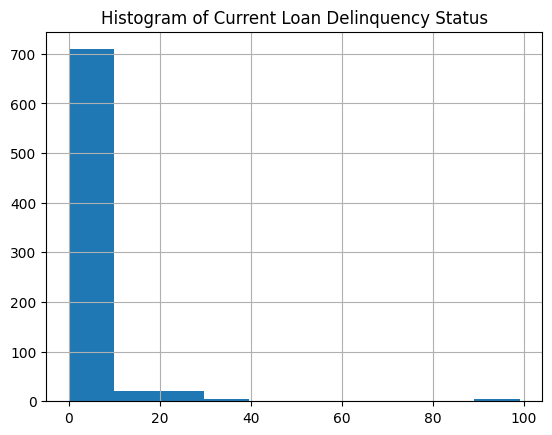

In [29]:
plt.title('Histogram of Current Loan Delinquency Status')
loan_data['Current Loan Delinquency Status'].hist()

<Axes: title={'center': 'Histogram of Current Loan Delinquency Status excluding 0 values'}>

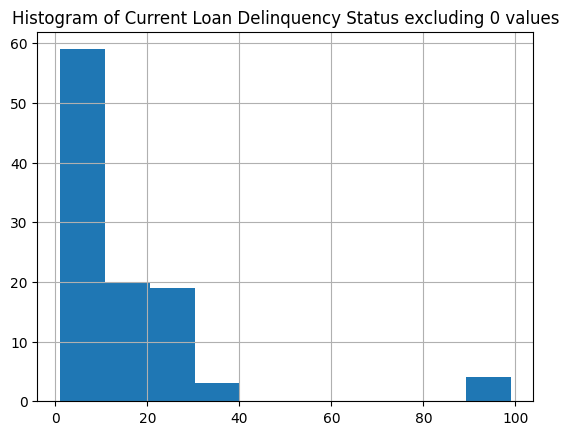

In [30]:
plt.title('Histogram of Current Loan Delinquency Status excluding 0 values')
loan_data['Current Loan Delinquency Status'].apply(lambda x: None if x == 0 else x).dropna().hist()

In [31]:
loan_data['Greater than 60 days delinquent'] = loan_data['Current Loan Delinquency Status'].apply(lambda x: 1 if x > 2 else 0)

<Axes: title={'center': ' 10.3% of These Loans are Greater than 60 days delinquent'}, ylabel='count'>

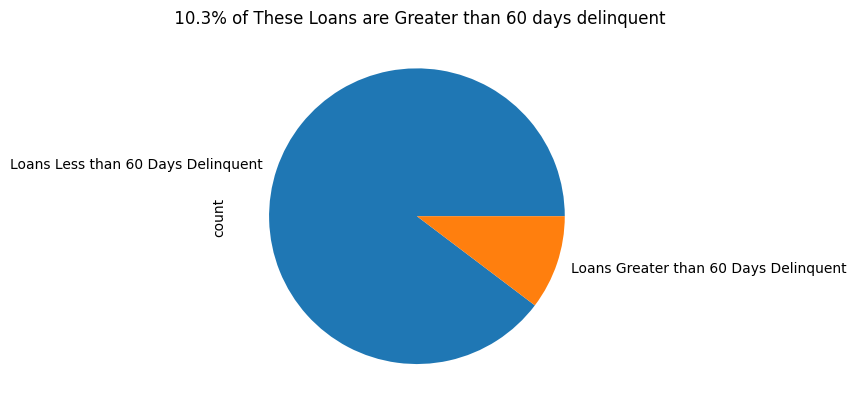

In [32]:
plt.title(f"{loan_data['Greater than 60 days delinquent'].sum() / loan_data.shape[0] * 100: .1f}% of These Loans are Greater than 60 days delinquent")
loan_data['Greater than 60 days delinquent'].value_counts().rename({1: "Loans Greater than 60 Days Delinquent", 0: "Loans Less than 60 Days Delinquent"}).plot.pie()

In [33]:
predictors = pd.get_dummies(loan_data.loc[:, loan_data.columns[~loan_data.columns.isin(['Greater than 60 days delinquent', 'Current Loan Delinquency Status'])]])

In [34]:
predictors = predictors.dropna(axis = 1)

In [35]:
outcome_variable = loan_data['Greater than 60 days delinquent']

In [36]:
model = DecisionTreeClassifier()
model.fit(predictors, outcome_variable)
model.score(predictors, outcome_variable)

1.0

In [37]:
pd.Series(model.feature_importances_, index = predictors.columns).sort_values(ascending = False).head(10)

Current Actual UPB                          0.527566
Property State_CA                           0.220630
Monthly Reporting Period                    0.120180
Original Combined Loan to Value Ratio (C    0.071070
Modification Flag_N                         0.024503
Repurchase Make Whole Proceeds Flag_N       0.019364
Zip Code Short                              0.009541
Original Interest Rate                      0.007147
Property State_FL                           0.000000
Property State_MN                           0.000000
dtype: float64

<Axes: title={'center': 'Histogram of Current Actual UPB for loans less than 60 days delinquent vs. loans greater than 60 days delinquent'}>

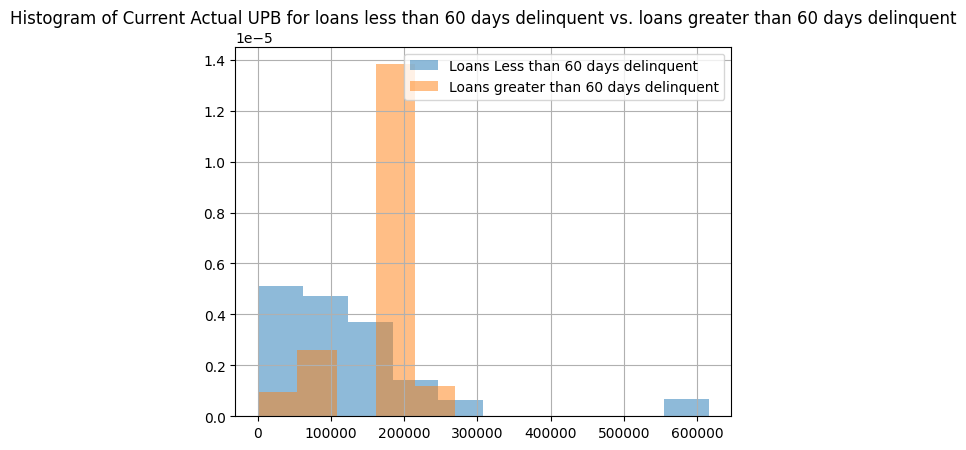

In [38]:
plt.title('Histogram of Current Actual UPB for loans less than 60 days delinquent vs. loans greater than 60 days delinquent')
loan_data.loc[loan_data['Greater than 60 days delinquent'] == 0, 'Current Actual UPB'].rename("Loans Less than 60 days delinquent").hist(alpha = 0.5, density = True, bins = 10, legend = True)
loan_data.loc[loan_data['Greater than 60 days delinquent'] == 1, 'Current Actual UPB'].rename("Loans greater than 60 days delinquent").hist(alpha = .5, density = True, bins = 5, legend = True)